In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Feature Correlation

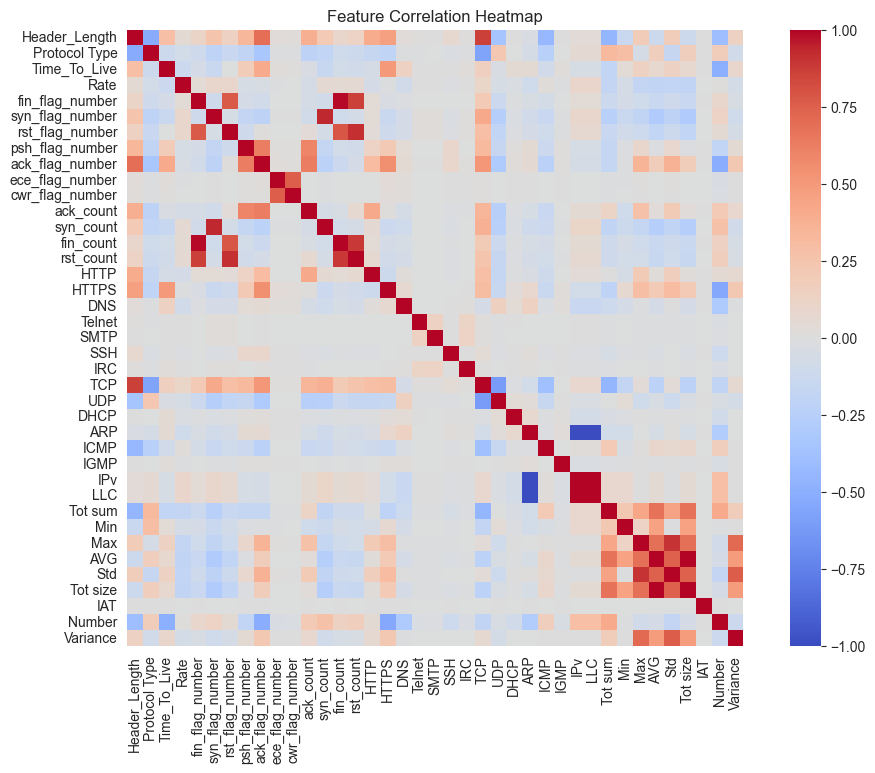

In [64]:
csv_path = "../data/processed/CIC_IOT_CSV_Dataset.csv"
df = pd.read_csv(csv_path)

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False, square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


# Feature Importance Study

/var/folders/09/s5nx4gn95nj0kqjmzvm1jcy00000gn/T/ipykernel_64261/769738.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(10), x="Importance", y="Feature", palette="viridis")


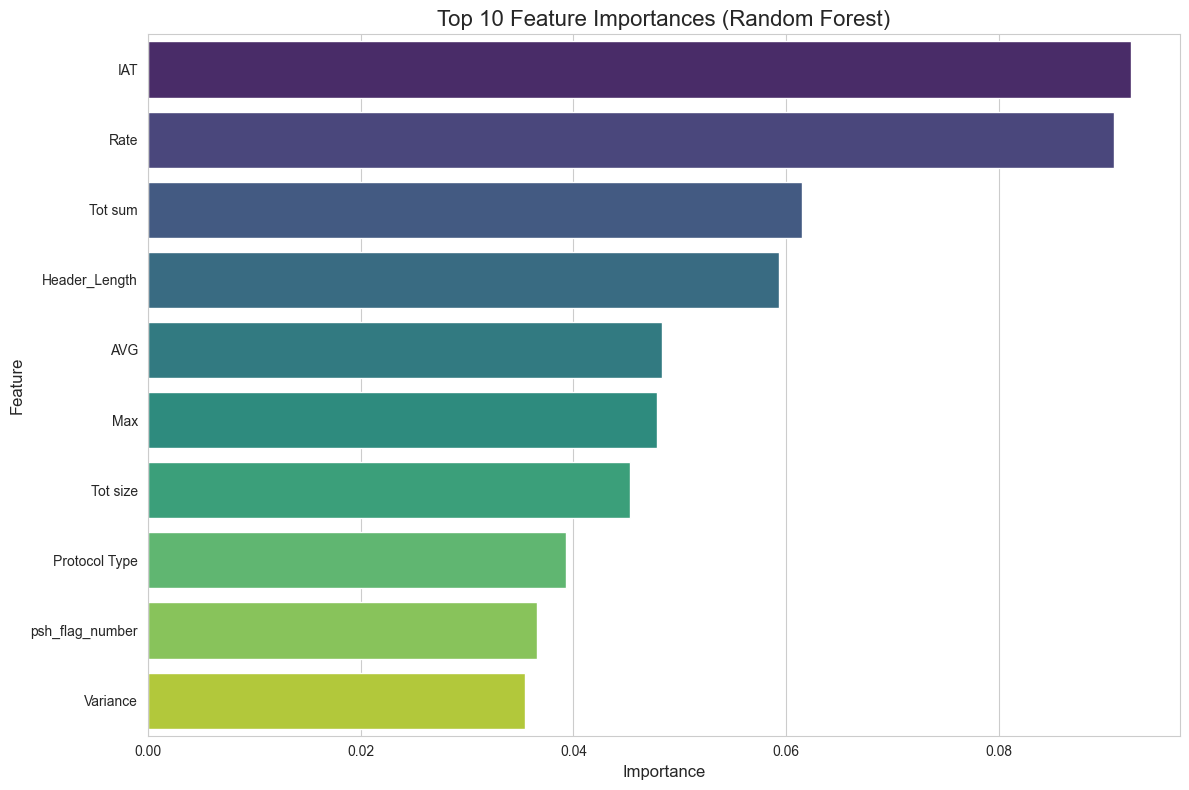

In [65]:
import pandas as pd

processed_data_path = "../data/processed/CIC_IOT_CSV_Dataset.csv"
df = pd.read_csv(processed_data_path)

df_sampled = df.sample(n=100000, random_state=42)
X = df_sampled.drop(columns=['label']).select_dtypes(include=['number'])
y = df_sampled['label']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid") 
sns.barplot(data=feature_importances.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()



/var/folders/09/s5nx4gn95nj0kqjmzvm1jcy00000gn/T/ipykernel_64261/1096289450.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plot = df_sampled.groupby('general_label').apply(lambda x: x.sample(n=min(100, len(x)), random_state=42)).reset_index(drop=True)


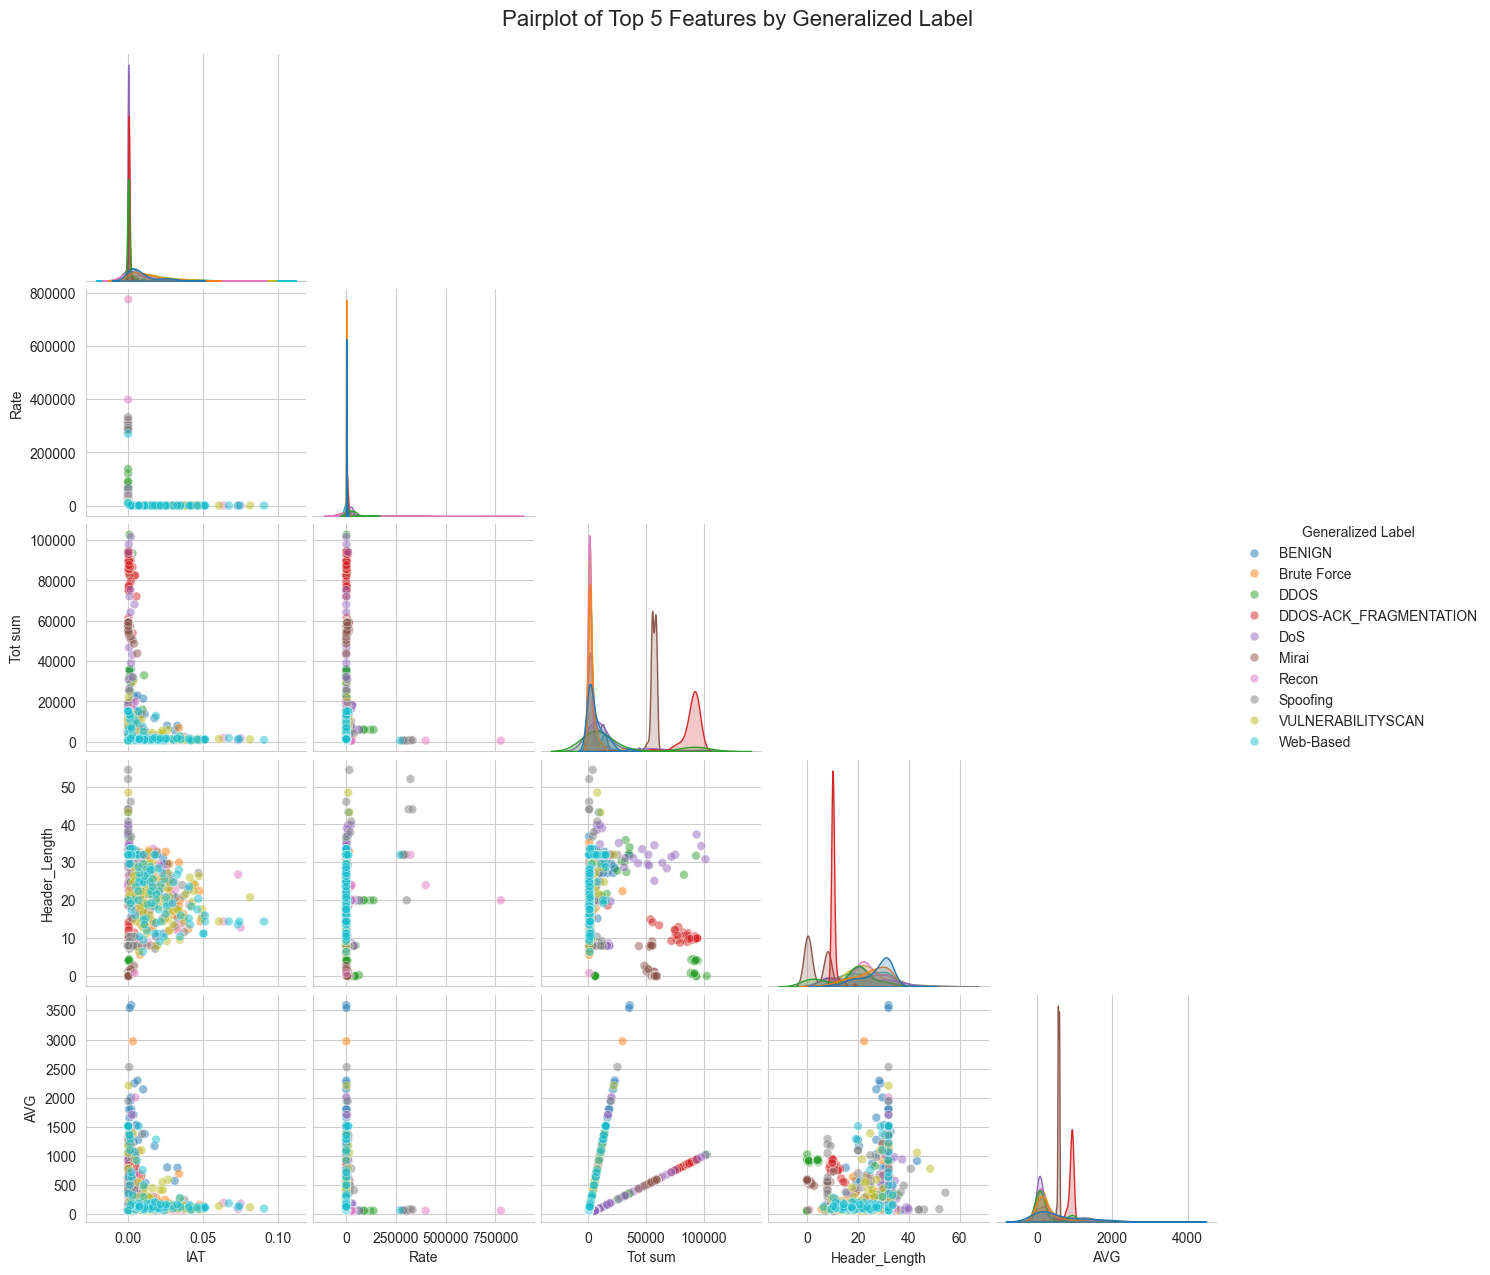

In [66]:
label_map = {
    'DDOS': ['DDOS-ACK_FRAGMENATION', 'DDOS-UDP_FLOOD', 'DDOS-SLOWLORIS', 'DDOS-ICMP_FLOOD', 'DDOS-RSTFINFLOOD',
             'DDOS-PSHACK_FLOOD', 'DDOS-HTTP_FLOOD', 'DDOS-UDP_FRAGMENTATION', 'DDOS-ICMP_FRAGMENTATION',
             'DDOS-TCP_FLOOD', 'DDOS-SYN_FLOOD', 'DDOS-SYNONYMOUSIP_FLOOD'],
    
    'DoS': ['DOS-TCP_FLOOD', 'DOS-HTTP_FLOOD', 'DOS-SYN_FLOOD', 'DOS-UDP_FLOOD'],

    'Recon': ['RECON-PINGSWEEP', 'RECON-OSSCAN', 'RECON-VULNERABILITYSCAN', 'RECON-PORTSCAN', 'RECON-HOSTDISCOVERY'],

    'Web-Based': ['SQLINJECTION', 'COMMANDINJECTION', 'BACKDOOR_MALWARE', 'UPLOADING_ATTACK', 'XSS', 'BROWSERHIJACKING'],

    'Brute Force': ['DICTIONARYBRUTEFORCE'],

    'Spoofing': ['MITM-ARPSPOOFING', 'DNS_SPOOFING'],

    'Mirai': ['MIRAI-GREIP_FLOOD', 'MIRAI-GREETH_FLOOD', 'MIRAI-UDPPLAIN']
}

flat_map = {}
for group, labels in label_map.items():
    for label in labels:
        flat_map[label] = group

df_sampled['general_label'] = df_sampled['label'].map(flat_map).fillna(df_sampled['label'])
y_general = df_sampled['general_label']

df_plot = df_sampled.groupby('general_label').apply(lambda x: x.sample(n=min(100, len(x)), random_state=42)).reset_index(drop=True)
top_features = feature_importances['Feature'].head(5).tolist()
g = sns.pairplot(df_plot[top_features + ['general_label']],
                 hue='general_label',
                 corner=True,
                 plot_kws={'alpha': 0.5, 's': 40})

g.figure.suptitle("Pairplot of Top 5 Features by Generalized Label", y=1.02, fontsize=16)
g.legend.set_title("Generalized Label")
plt.show()

Now we can try to visualize how well the top-5 features do at separating the labels. From the clustering you see below, this suggests the top 5 features you selected do a pretty good job separating attack types.

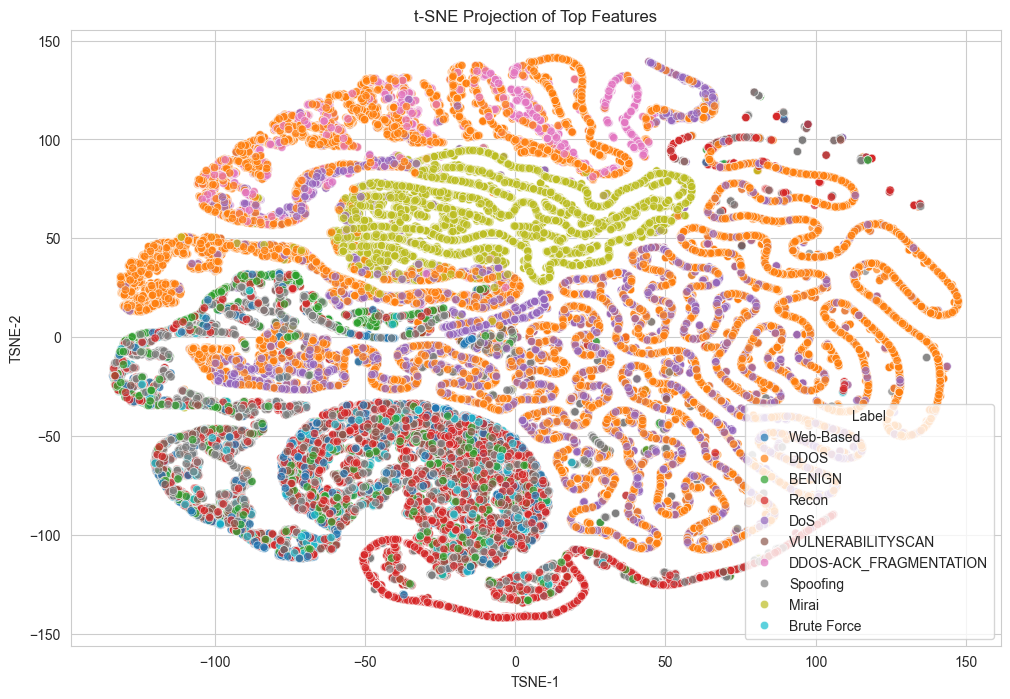

In [67]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_embedded = tsne.fit_transform(df_sampled[top_features])

df_tsne = pd.DataFrame(X_embedded, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Label'] = df_sampled['general_label'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_tsne, x='TSNE-1', y='TSNE-2', hue='Label', alpha=0.7)
plt.title("t-SNE Projection of Top Features")
plt.show()

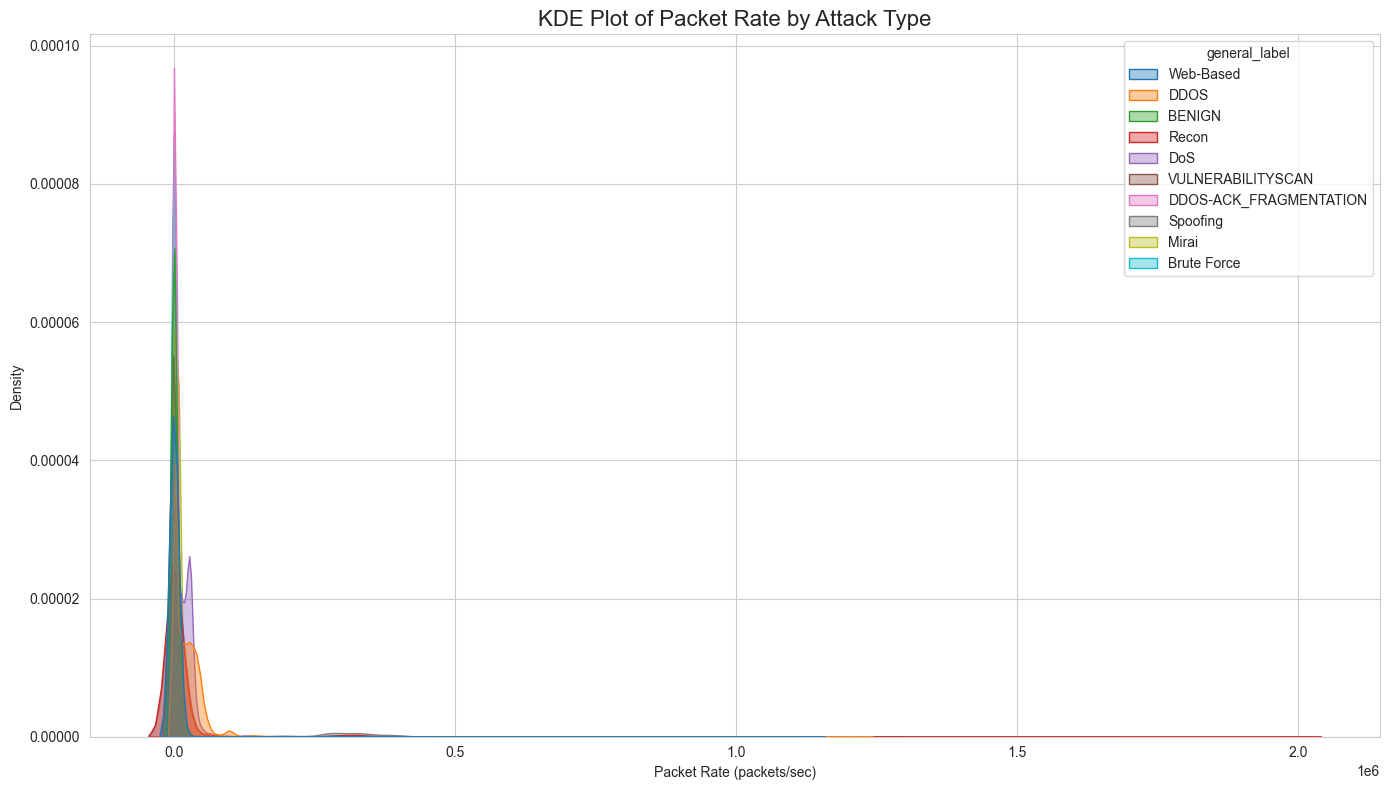

In [68]:
df_sampled = df_sampled[df_sampled['Rate'].notna()]
df_sampled = df_sampled[df_sampled['Rate'] > 0]
df_sampled['Rate'] = df_sampled['Rate'].astype(float)

# Create KDE without log scale to avoid transformation issues
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df_sampled, x='Rate', hue='general_label', common_norm=False, fill=True, alpha=0.4, warn_singular=False)
plt.title("KDE Plot of Packet Rate by Attack Type", fontsize=16)
plt.xlabel("Packet Rate (packets/sec)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# Training a Model

In [69]:
!pip install tensorflow keras

Training a model based on all distinct attack types...

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(pd.factorize(y_train)[0])
y_test_encoded = to_categorical(pd.factorize(y_test)[0])

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/Users/jle/dev/github.com/cybertoad/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 526us/step - accuracy: 0.5406 - loss: 1.3911 - val_accuracy: 0.6417 - val_loss: 0.8979
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.6342 - loss: 0.8962 - val_accuracy: 0.6424 - val_loss: 0.8642
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 510us/step - accuracy: 0.6431 - loss: 0.8721 - val_accuracy: 0.6561 - val_loss: 0.8549
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - accuracy: 0.6497 - loss: 0.8574 - val_accuracy: 0.6521 - val_loss: 0.8366
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - accuracy: 0.6581 - loss: 0.8322 - val_accuracy: 0.6855 - val_loss: 0.8257
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.6611 - loss: 0.8266 - val_accuracy: 0.6966 - val_loss: 0.8093
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.6675 - loss: 0.8151 - val_accuracy: 0.6802 - val_loss: 0.8103
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step - accuracy: 0.6774 - loss: 0.79

In [72]:
model.evaluate(X_test, y_test_encoded)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - accuracy: 0.0973 - loss: 20.6396


[20.403453826904297, 0.0949999988079071]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

# Use top 5 features
top_features = ['Rate', 'Tot sum', 'Header_Length', 'AVG', 'IAT']
X = df_sampled[top_features]
y = df_sampled['general_label'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

y_train_factorized, class_names = pd.factorize(y_train)
y_test_factorized = pd.Series(y_test).map(dict(zip(class_names, range(len(class_names))))).fillna(-1).astype(int)
y_train_encoded = to_categorical(y_train_factorized)
y_test_encoded = to_categorical(y_test_factorized)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict
)

loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50


/Users/jle/dev/github.com/cybertoad/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 739us/step - accuracy: 0.5884 - loss: 1.1005 - val_accuracy: 0.7051 - val_loss: 0.7231
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.6916 - loss: 0.7490 - val_accuracy: 0.7074 - val_loss: 0.7027
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 706us/step - accuracy: 0.6979 - loss: 0.7291 - val_accuracy: 0.7078 - val_loss: 0.7033
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step - accuracy: 0.6983 - loss: 0.7191 - val_accuracy: 0.7081 - val_loss: 0.6871
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.6999 - loss: 0.7106 - val_accuracy: 0.7067 - val_loss: 0.6893
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 789us/step - accuracy: 0.7014 - loss: 0.7032 - val_accuracy: 0.7077 - val_loss: 0.6856
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 783us/step - accuracy: 0.7011 - loss: 0.7075 - val_accuracy: 0.7064 - val_loss: 0.6843
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.6952 - loss: 0.71